# Exploratory Analysis using Data from Sylvia Beach's bookstore

In [106]:
from IPython.display import Image
Image(url= "https://www.nybooks.com/wp-content/uploads/2019/11/beach-lead.jpg", width=700)

-------

## Cultural Context
In the aftermath of World War I, emigrant Sylvia Beach opened an American bookstore in Paris that would in its course change Modernist literature culture fundamentally. Sylvia Beach was one of many expatriates in Paris when the city became the hotbed of art, cinema, literature, and music.1 Her bookstore, which also functioned as a lending library, quickly established itself as a meeting point for the Lost Generation and other avant garde movements.2 It was at this address that expatriate writers such as Ernest Hemingway, F. Scott Fitzgerald, and James Joyce met, exchanged ideas, and influenced each other’s work.
## Source Documents
The datasets used in this notebook derive from Princeton's "Shakespeare and Company Project." The project's aim is to digitally recreate the cultural and intellectual landscape of interwar Paris, using documents from Princeton's collection Sylvia Beach Papers. The project itself focuses on Beach's bookkeeping and business documents, such as lending library cards, logbooks, and address books.
## Datasets
The project resulted in three datasets (in CSV format): members, books, and events.
Members: The members dataset records the members of the lending library cards

Books: The books dataset records the books available to purchase and/or borrow at the lending library

Events: The events dataset brings the previous two datasets together by recording events. Such events include borrows, purchases, subscriptions (to the library), renewal of subscriptions, gifts, payments of deposit, and other processes inherent to libraries

---------

## Analysis

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
from scipy.stats import entropy
import numpy as np
import networkx as nx
from networkx.algorithms.community import girvan_newman
import geopandas as gpd

In [108]:
books = pd.read_csv('../data/SCoData_books_v1.2_2022_01.csv', encoding='utf-8')
members = pd.read_csv('../data/SCoData_members_v1.2_2022_01.csv', encoding='utf-8')
events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')

C:\Users\dittm\AppData\Local\Temp\ipykernel_17972\3882839150.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')


In [109]:
books.columns

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')

In [110]:
members.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

### Unique Authors

In [111]:
# Filter books of format 'Book', select relevant columns, and drop rows with any missing values
book_authors = books[(books['format'] == 'Book')][['author']].dropna()

# Remove duplicate entries to ensure all authors are unique across the dataset.
# Here we consider only the 'author' column for uniqueness.
unique_authors = book_authors.drop_duplicates(subset=['author'])

unique_authors.shape

(1995, 1)

#### Quick check

In [112]:
unique_authors.loc[unique_authors['author'] == 'Hemingway, Ernest']

,author
2140,"Hemingway, Ernest"


### Unique Members

In [113]:
member_filtered = members[['sort_name']].dropna()

unique_members = member_filtered.drop_duplicates(subset=['sort_name'])

unique_members.shape

(4804, 1)

#### Quick check

In [114]:
unique_members.loc[unique_members['sort_name'] == 'Hemingway, Ernest']

,sort_name
2270,"Hemingway, Ernest"


### Intersection of Authors and Members

In [115]:
unique_members.rename(columns={'sort_name': 'member'}, inplace=True)

merged_df = pd.merge(unique_members, unique_authors, how='outer', left_on='member', right_on='author')

merged_df.sample(3)

C:\Users\dittm\AppData\Local\Temp\ipykernel_17972\2510572786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_members.rename(columns={'sort_name': 'member'}, inplace=True)


,member,author
6275,NaN,"Phare, Elsie Elizabeth"
4787,"Zacks-Abramov, Ayala",NaN
1259,"de Pourtales, Mme G.",NaN


In [116]:
member_is_author = merged_df.dropna().reset_index(drop=True)
member_is_author = member_is_author[['member']]  # Keep the 'member' column as it now represents both member and author
member_is_author.columns = ['name']  # Rename the column

member_is_author.shape

(84, 1)

In [117]:
member_is_author.head(5)

,name
0,"Aldington, Richard"
1,"Anderson, Margaret C."
2,"Antheil, George"
3,"Aragon, Louis"
4,"Asch, Nathan"


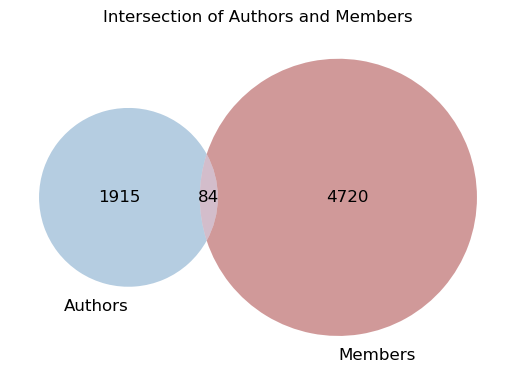

In [118]:
# Extract unique authors and members
unique_authors = set(books['author'])
unique_members = set(members['sort_name'])

# Calculate the intersection
intersection = len(unique_authors.intersection(unique_members))

# Create the Venn diagram for authors with customized colors
venn = venn2(subsets=(len(unique_authors) - intersection, len(unique_members) - intersection, intersection),
             set_labels=('Authors', 'Members'),
             set_colors=('steelblue', 'darkred'))

# Optionally, you can customize more properties, such as the transparency (alpha)
for subset in venn.subset_labels:
    if subset:  # If the subset is not None
        subset.set_fontsize(12)

plt.title('Intersection of Authors and Members')
plt.show()

matched_members = members[members['sort_name'].isin(member_is_author['name'])]

In [119]:
# Calculate the percentages
percent_intersection_authors = (intersection / len(unique_authors)) * 100
percent_intersection_members = (intersection / len(unique_members)) * 100

print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.20%
Percent of the intersection relative to members: 1.75%


### Coordinates

In [120]:
# Split the coordinates and create a new DataFrame
coordinate_list = matched_members['coordinates'].str.split(';').explode().str.strip()

# Create a DataFrame from the exploded list
coordinates_df = coordinate_list.str.split(',', expand=True)
coordinates_df.columns = ['latitude', 'longitude']

# Convert to numeric values
coordinates_df['latitude'] = pd.to_numeric(coordinates_df['latitude'])
coordinates_df['longitude'] = pd.to_numeric(coordinates_df['longitude'])

In [121]:
coordinates_df.sample(3)

,latitude,longitude
2593,48.86816,2.30039
3872,48.83962,2.33507
2593,48.85693,2.30038


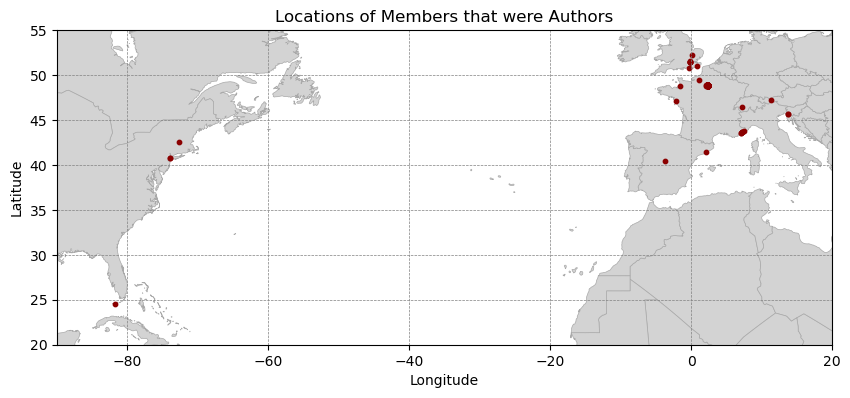

In [122]:
# Load the map of the world
world_map = gpd.read_file('../data/world.shp') # If this throws an error, try world.shx

# Create a GeoDataFrame from the coordinates
gdf = gpd.GeoDataFrame(coordinates_df, geometry=gpd.points_from_xy(coordinates_df.longitude, coordinates_df.latitude))

# Set the coordinate reference system (CRS) for your GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)  # EPSG 4326 is WGS84 latitude-longitude

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

world_map.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth=0.5) 

gdf.plot(ax=ax, marker='o', color='darkred', markersize=10)  # Plot the scatter points

# Set limits for the axes
ax.set_xlim(-90, 20)  # Set longitude bounds
ax.set_ylim(20, 55)    # Set latitude bounds

# Here I experimented with different basemaps and then opted to not use one after all
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.NatGeoWorldMap)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.DarkMatter)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Locations of Members that were Authors')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)


plt.show()

world data from https://www.kaggle.com/datasets/venkatkumar001/geographical-data/data

### Members with the same address

In [123]:
# Split the addresses by semicolon and create a new DataFrame
addresses_df = matched_members.assign(addresses=matched_members['addresses'].str.split(';')).explode('addresses')

# Normalize and clean addresses
addresses_df['addresses'] = addresses_df['addresses'].str.strip()

# Group by addresses to find common addresses
grouped_addresses = addresses_df.groupby('addresses').agg(names=('name', ', '.join)).reset_index()

# Filter to find addresses with more than one resident
common_addresses = grouped_addresses[grouped_addresses['names'].str.contains(',')]

# Display the result
common_addresses

,addresses,names
10,"12 rue de l'Odéon, Paris","George Antheil, Sylvia Beach, Padraic Colum, R..."
46,"34 rue des Vignes, Paris","Pierre de Lanux, James Joyce"
49,"4 boulevard Raspail, Paris","Stephen Vincent Benét, Margaret Wilson"
65,"6 via Cesare Battista, Trieste","James Joyce, Stanislaus Joyce"
69,"69 rue Raynouard, Paris","Élisabeth de Gramont, Duchesse de Clermont-Ton..."
75,"71 rue du Cardinal Lemoine, Paris","James Joyce, Valery Larbaud"
99,"Hotel Jacob, 44 rue Jacob, Paris","David Gascoyne, Ernest Hemingway"
142,"Select Hôtel, 1 place de la Sorbonne, Paris","Richard Aldington, Katherine Mansfield"
149,"École normale supérieure, 45 rue d'Ulm, Paris","Samuel Beckett, Thomas MacGreevy"


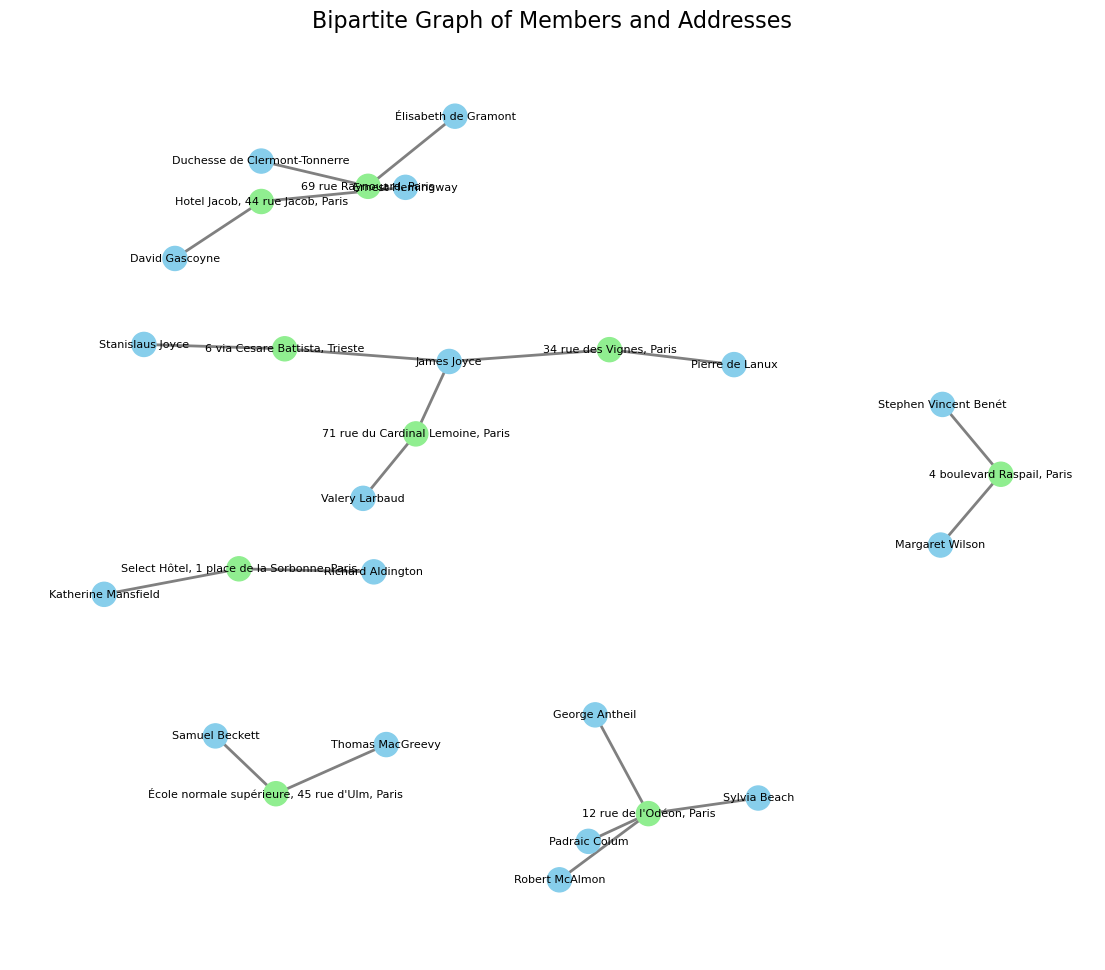

In [124]:
# Create a bipartite graph
B = nx.Graph()

# Add nodes and edges for the bipartite graph
for _, row in common_addresses.iterrows():
    address = row['addresses']
    residents = row['names'].split(', ')
    B.add_node(address, bipartite=0)  # Add address node
    for resident in residents:
        B.add_node(resident, bipartite=1)  # Add resident node
        B.add_edge(resident, address)

# Separate nodes by type for layout
people = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]
addresses = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]

# Create a bipartite layout
pos = nx.spring_layout(B, k=0.3, iterations=35)

# Draw the bipartite graph
fig, ax = plt.subplots(figsize=(14, 12))
nx.draw(B, pos, ax=ax, with_labels=True, node_size=300, 
        node_color=['skyblue' if node in people else 'lightgreen' for node in B.nodes()], 
        font_size=8, edge_color='gray', width=2)
plt.title('Bipartite Graph of Members and Addresses', size=16)
plt.show()

### Gender

In [125]:
count_gender = matched_members['gender'].value_counts().sort_index()  # operate on series ; count

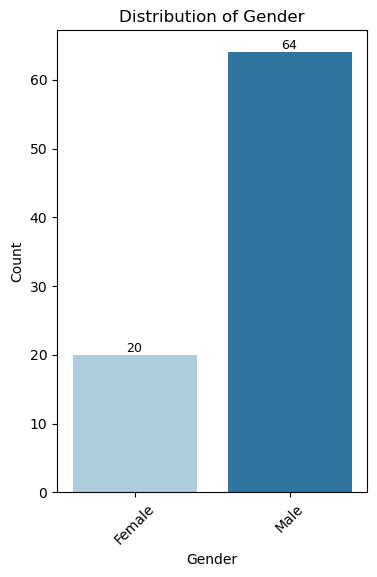

In [126]:
plt.figure(figsize=(4, 6))
ax = sns.barplot(x=count_gender.index, y=count_gender.values, palette='Paired')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, count in enumerate(count_gender.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.show()

In [127]:
percentages = matched_members['gender'].value_counts(normalize=True) * 100
print(percentages)

Male      76.190476
Female    23.809524
Name: gender, dtype: float64


#### Mode

In [128]:
mode_gender = matched_members['gender'].value_counts().idxmax() # Mode
print(f"Mode of gender distribution: {mode_gender}")

Mode of gender distribution: Male


#### Entropy

In [129]:
# Assuming `members` DataFrame and 'gender' column exist
gender_counts = matched_members['gender'].value_counts(normalize=True)
entropy_gender = entropy(gender_counts)

# Calculate the number of unique categories (genders)
num_categories = gender_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_categories)

# Print the entropy and the benchmark
print(f"Entropy of gender distribution: {entropy_gender}")
print(f"Maximum possible entropy with {num_categories} categories: {max_entropy}")

# Calculate the normalized entropy (entropy divided by maximum possible entropy)
normalized_entropy = entropy_gender / max_entropy

print(f"Normalized entropy: {normalized_entropy}")

Entropy of gender distribution: 0.5488743844849944
Maximum possible entropy with 2 categories: 0.6931471805599453
Normalized entropy: 0.7918583525674836


### Age

C:\Users\dittm\AppData\Local\Temp\ipykernel_17972\1030809175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birth_year'] = df['birth_year'].astype(int)


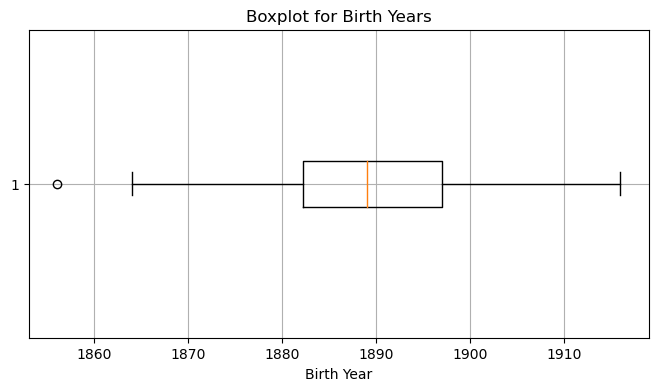

In [130]:
# Cleaning: Remove NaN values
df = matched_members.dropna(subset=['birth_year'])

# Convert birth_year to integer
df['birth_year'] = df['birth_year'].astype(int)

# Plotting a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(df['birth_year'], vert=False)  # 'vert=False' makes the boxplot horizontal
plt.title('Boxplot for Birth Years')
plt.xlabel('Birth Year')
plt.grid(True)
plt.show()

#### Entropy

In [131]:
# Group birth years into bins (e.g., by decade)
matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))

# Calculate the normalized value counts for each bin
birth_year_group_counts = matched_members['birth_year_group'].value_counts(normalize=True)

# Calculate the entropy of the birth year distribution
entropy_birth_year = entropy(birth_year_group_counts)

# Calculate the number of unique bins
num_bins = birth_year_group_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_bins)

# Calculate the normalized entropy
normalized_entropy = entropy_birth_year / max_entropy

# Print the results
print(f"Entropy of birth year distribution: {entropy_birth_year}")
print(f"Maximum possible entropy with {num_bins} bins: {max_entropy}")
print(f"Normalized entropy: {normalized_entropy}")


Entropy of birth year distribution: 1.4401361309075074
Maximum possible entropy with 6 bins: 1.791759469228055
Normalized entropy: 0.803755278339878


C:\Users\dittm\AppData\Local\Temp\ipykernel_17972\827458227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))


In [132]:
print(matched_members['birth_year'].mean())
print(matched_members['birth_year'].median())
print(matched_members['birth_year'].mode())

1888.8658536585365
1889.0
0    1883.0
1    1888.0
2    1892.0
3    1899.0
Name: birth_year, dtype: float64


MULTIMODAL

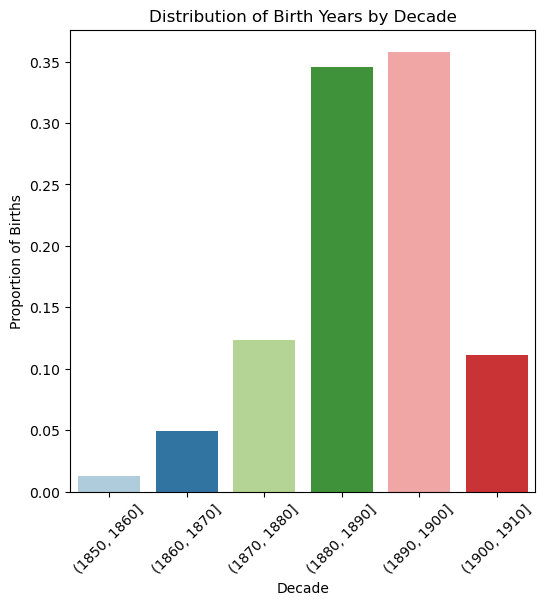

In [133]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=birth_year_group_counts.index, y=birth_year_group_counts.values, palette='Paired')
plt.xlabel('Decade')
plt.ylabel('Proportion of Births')
plt.title('Distribution of Birth Years by Decade')
plt.xticks(rotation=45)

plt.show()

### Borrow


books by member

events from authors that are members

In [145]:
books_by_member_events = events[events['item_authors'].isin(member_is_author['name'])]
books_by_member_events.shape

(1746, 28)

take these events and filter by borrow

In [135]:
borrow_by_author = books_by_member_events[books_by_member_events['event_type'] == 'Borrow']
borrow_by_author.shape

(1539, 28)

only unique

In [146]:
borrow_by_author['event_type'].unique()

array(['Borrow'], dtype=object)

In [147]:
borrow_by_author = borrow_by_author[borrow_by_author['member_sort_names'].isin(member_is_author['name'])]
borrow_by_author.event_type.unique()

array(['Borrow'], dtype=object)

In [148]:
borrow_by_author.member_sort_names.unique()

array(['Joyce, James', 'Hemingway, Ernest', 'Beach, Sylvia',
       'Wilson, Romer', 'Aragon, Louis', 'Stein, Gertrude',
       'Rodker, John', 'Mansfield, Katherine', 'Solano, Solita',
       'de Lanux, Pierre', 'Wickham, Anna', 'Le Gallienne, Richard',
       'Gilbert, Stuart', 'Porter, Katherine Anne', 'Connolly, Cyril',
       'Gascoyne, David', 'Dennis, Mary Cable', 'Merrick, Leonard',
       'Rogers, Samuel', 'Ford, Ford Madox', 'Paul, Elliot'], dtype=object)

only member borrow book by member

In [149]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix = borrow_by_author.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix.tail(2))

item_title         A Companion Volume  A Farewell to Arms  A Good Woman  \
member_sort_names                                                         
Wilson, Romer                       0                   0             0   
de Lanux, Pierre                    2                   0             0   

item_title         A Hasty Bunch  A Mirror to France  A Modern Hero  \
member_sort_names                                                     
Wilson, Romer                  0                   0              0   
de Lanux, Pierre               1                   0              0   

item_title         A Portrait of the Artist as a Young Man  \
member_sort_names                                            
Wilson, Romer                                            1   
de Lanux, Pierre                                         0   

item_title         A. O. Barnabooth: His Diary  \
member_sort_names                                
Wilson, Romer                                0   
de Lanux, Pierr

In [150]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts = user_book_matrix.sum(axis=0).reset_index()
borrow_counts.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts.sort_values(by='borrow_count', ascending=False).head(15))

                                           book_title  borrow_count
6             A Portrait of the Artist as a Young Man             4
0                                  A Companion Volume             3
35               The Autobiography of Alice B. Toklas             3
47                                        Three Lives             3
4                                  A Mirror to France             2
49  To Return to Yesterday: Reminiscences 1894 – 1914             2
8   Back to Montparnasse: Glimpses of Broadway in ...             2
28              Oscar Wilde: His Life and Confessions             2
11                             Death in the Afternoon             2
12                Distinguished Air: Grim Fairy Tales             2
46                              This Side of Paradise             2
31                                 Strait Is the Gate             2
37                                 The Counterfeiters             2
17                                Geography and 

In [151]:
print(borrow_counts.sort_values(by='borrow_count', ascending=False).shape)

(54, 2)


In [141]:
# Create an empty graph
G = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in user_book_matrix.index:
    for user2 in user_book_matrix.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((user_book_matrix.loc[user1] > 0) & (user_book_matrix.loc[user2] > 0))
            if common_books > 0:
                G.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 14
Number of edges: 18


müsste 18, 31 sein

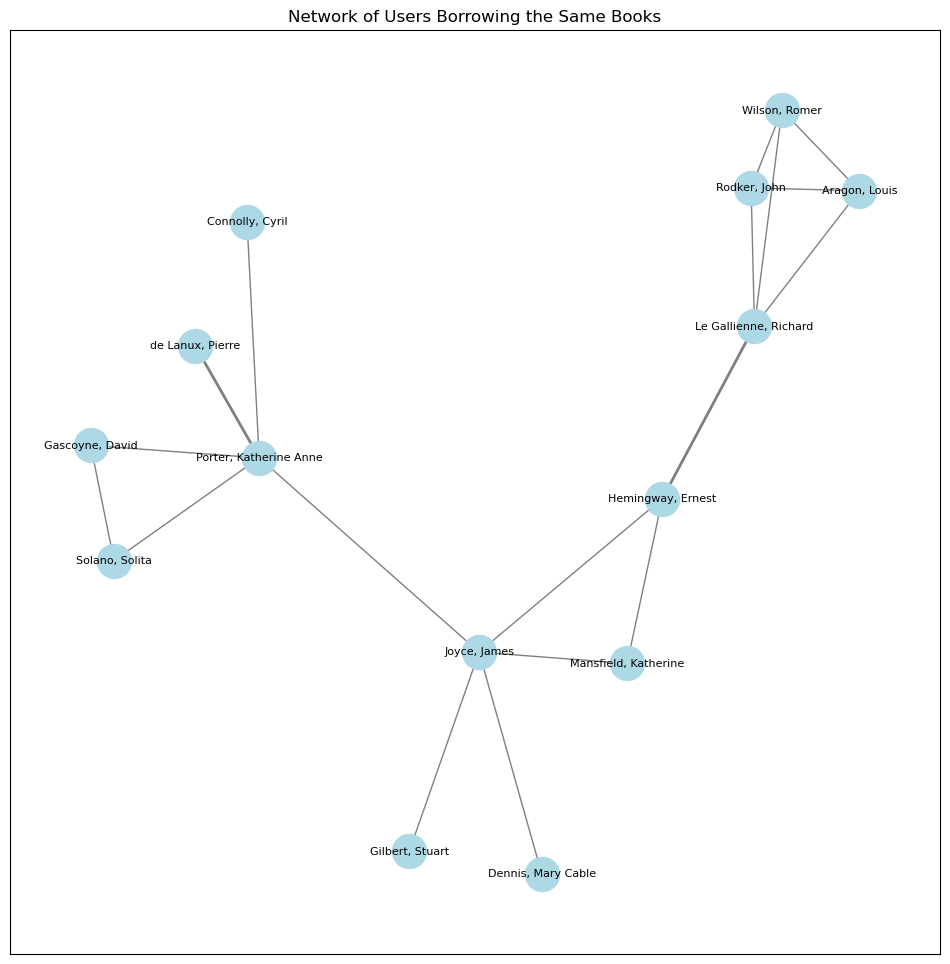

In [142]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

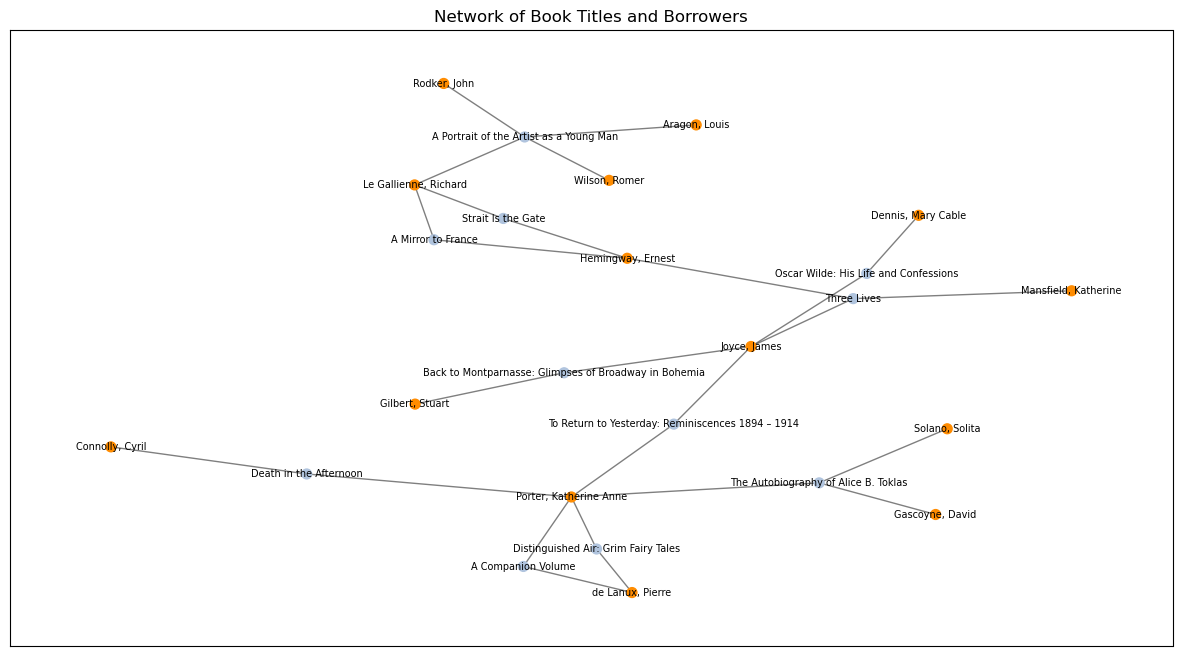

In [143]:
# Convert pivot table to edge list
edge_list = user_book_matrix.stack().reset_index()
edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
edge_list = edge_list[edge_list['borrowed'] > 0]

# Filter books that were only borrowed once overall
book_counts = edge_list['item_title'].value_counts()
books_multi_borrowed = book_counts[book_counts > 1].index
edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]

# Create a graph from the edge list
G_T = nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

# Visualization
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G_T,  seed=42, k=0.2, iterations=25)  # Positions for all nodes
#0.3
#0.6

# Assign colors to nodes
node_colors = ['lightsteelblue' if node in edge_list['item_title'].unique() else 'darkorange' for node in G_T]

# Draw nodes and edges with the assigned colors
nx.draw_networkx_nodes(G_T, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_T, pos, alpha=0.5)
nx.draw_networkx_labels(G_T, pos, font_size=7)

plt.title('Network of Book Titles and Borrowers')
plt.show()